In [1]:
# Environment Setup and Spark Initialization
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz

In [2]:
import os
import pandas as pd
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!pip install findspark

import findspark
findspark.init()
findspark.find()

!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, LinearSVC, RandomForestClassifier

# Spark Session Creation
spark_session = SparkSession.builder \
    .appName("MarketingCampaignAnalysis") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "512m") \
    .getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=ad3ea7460196a81454cd24ed7b10848d214d20a8858b9c7b829f622e62196451
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
# Data Loading
marketing_data = spark_session.read.csv('/content/marketing_campaign.csv', inferSchema=True, header=True, sep='\t')
marketing_data.printSchema()


root
 |-- ID: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedC

In [4]:
from pyspark.sql.functions import mean
# Correct DataFrame name and optimized mean calculation
mean_income = marketing_data.select(mean('Income')).first()[0]
marketing_data = marketing_data.fillna({'Income': mean_income})


In [5]:
from pyspark.sql.functions import mean as _mean

# Calculate mean income
mean_income = marketing_data.select(_mean('Income')).first()[0]

# Fill missing values in 'Income' column with the calculated mean
marketing_data = marketing_data.fillna({'Income': mean_income})


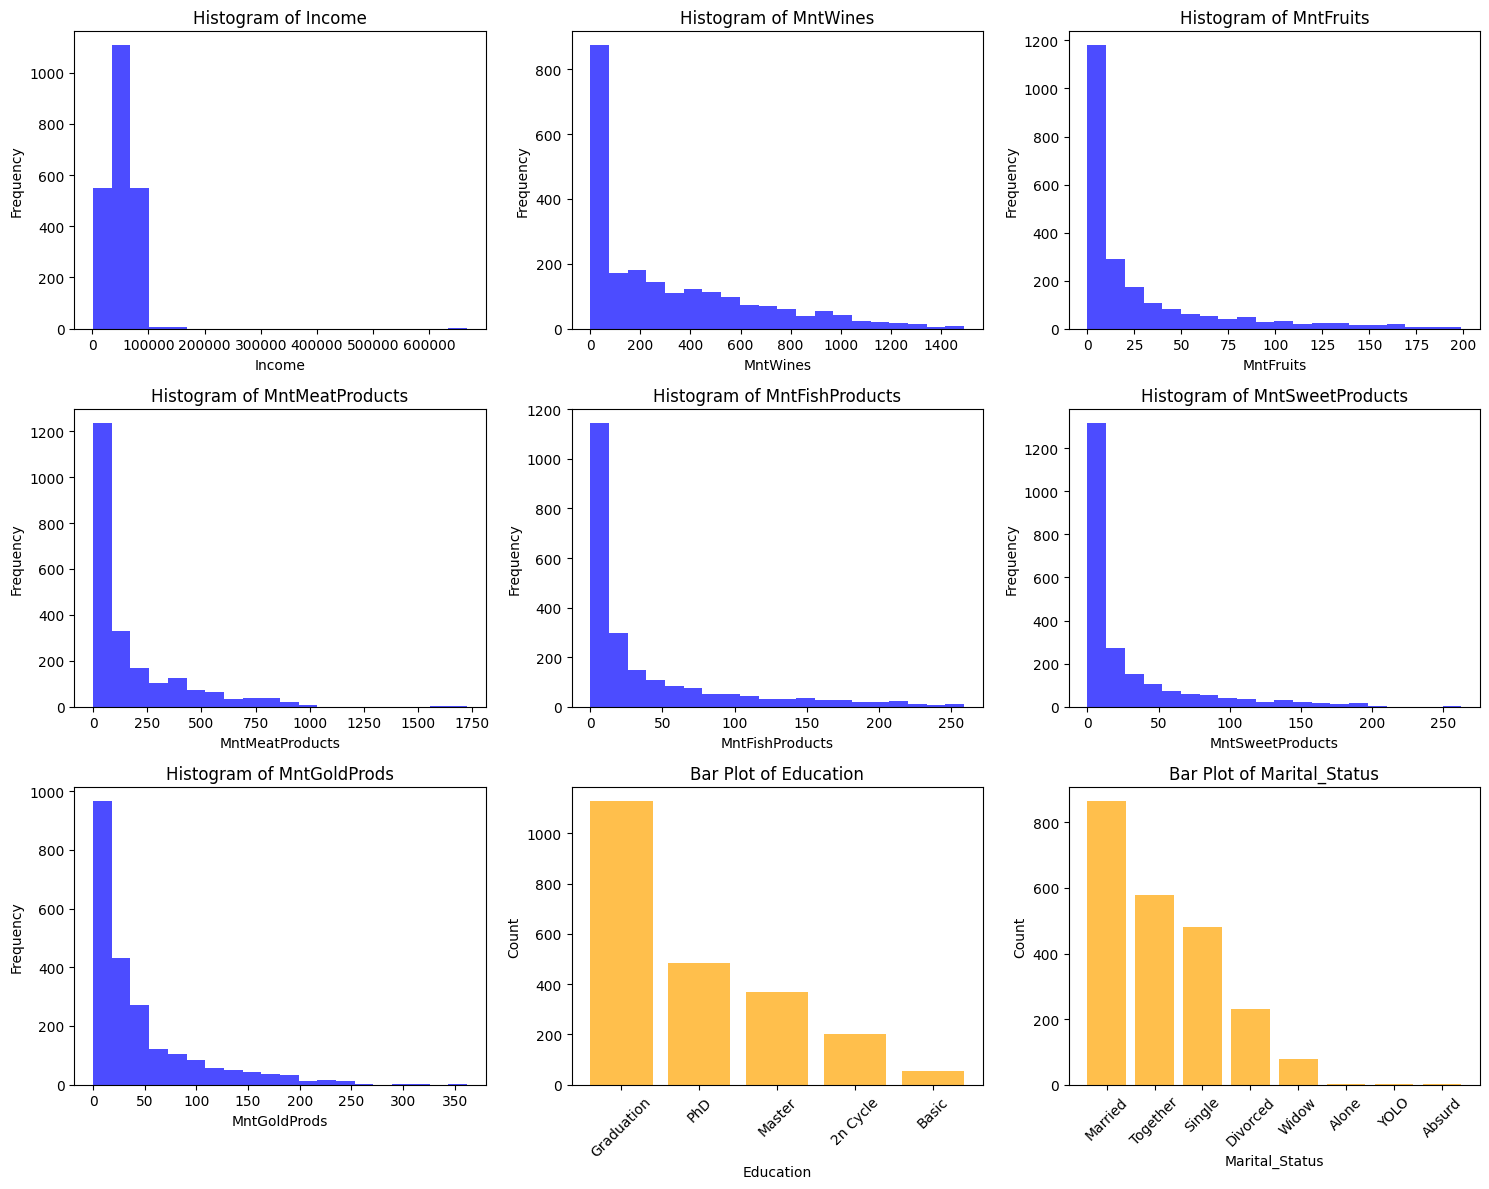

In [6]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import math

# Start Spark Session
spark = SparkSession.builder.appName("FeatureDistributionPlots").getOrCreate()

# Load your dataset
file_path = "/content/marketing_campaign.csv"  # Update with your dataset path
data = spark.read.csv(file_path, header=True, inferSchema=True, sep='\t')

# Define your features
numeric_features = ['Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
categorical_features = ['Education', 'Marital_Status']

# Calculate the layout size (you can adjust these)
num_plots = len(numeric_features) + len(categorical_features)

cols = 3  # Number of columns in the subplot grid
rows = math.ceil(num_plots / cols)  # Number of rows in the subplot grid

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Plot Numeric Features
for i, feature in enumerate(numeric_features):
    # Filter out None values
    feature_data = data.select(feature).rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()

    axes[i].hist(feature_data, bins=20, color='blue', alpha=0.7)
    axes[i].set_title(f"Histogram of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")

# Plot Categorical Features
for i, category in enumerate(categorical_features, start=len(numeric_features)):
    category_counts = data.groupBy(category).count().orderBy('count', ascending=False).toPandas()
    axes[i].bar(category_counts[category], category_counts['count'], color='orange', alpha=0.7)
    axes[i].set_title(f"Bar Plot of {category}")
    axes[i].set_xlabel(category)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [7]:
# Encoding categorical variables
# 'Education' and 'Marital_Status' are being indexed and encoded
indexer_education = StringIndexer(inputCol="Education", outputCol="Education_Indexed")
indexer_marital = StringIndexer(inputCol="Marital_Status", outputCol="Marital_Status_Indexed")


In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml import Pipeline
encoder_education = OneHotEncoder(inputCol="Education_Indexed", outputCol="Education_Vec")
encoder_marital = OneHotEncoder(inputCol="Marital_Status_Indexed", outputCol="Marital_Status_Vec")


In [9]:
# Feature Engineering
# Including relevant features in the analysis
feature_columns = ['Year_Birth', 'Education_Vec', 'Marital_Status_Vec', 'Income',
                   'Kidhome', 'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts',
                   'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                   'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                   'NumStorePurchases', 'NumWebVisitsMonth']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")



In [10]:
# Handling missing values in 'Income'
marketing_data = marketing_data.fillna({'Income': marketing_data.groupBy().mean('Income').first()[0]})


In [17]:
# Handling Categorical Variables
indexer = StringIndexer(inputCols=["Education", "Marital_Status"], outputCols=["Education_Indexed", "Marital_Status_Indexed"])
encoder = OneHotEncoder(inputCols=["Education_Indexed", "Marital_Status_Indexed"], outputCols=["Education_Vec", "Marital_Status_Vec"])

# Numeric feature columns for scaling
numeric_features = ['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'MntWines', 'MntFruits',
                    'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                    'NumStorePurchases', 'NumWebVisitsMonth']

# Assemble features with handling null values
assembler = VectorAssembler(
    inputCols=numeric_features + ["Education_Vec", "Marital_Status_Vec"],
    outputCol="assembled_features",
    handleInvalid="skip"  # or "keep"
)
# Scale features
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features")

# Pipeline for preprocessing
pipeline = Pipeline(stages=[indexer, encoder, assembler, scaler])
scaled_data = pipeline.fit(data).transform(data)

# Show scaled data
scaled_data.select("scaled_features").show()
# Apply the pipeline
scaled_data = pipeline.fit(data).transform(data)


+--------------------+
|     scaled_features|
+--------------------+
|(26,[0,1,4,5,6,7,...|
|[163.029592468456...|
|(26,[0,1,4,5,6,7,...|
|(26,[0,1,2,4,5,6,...|
|(26,[0,1,2,4,5,6,...|
|(26,[0,1,3,4,5,6,...|
|(26,[0,1,3,4,5,6,...|
|(26,[0,1,2,4,5,6,...|
|(26,[0,1,2,4,6,7,...|
|(26,[0,1,2,3,4,6,...|
|(26,[0,1,4,5,6,7,...|
|(26,[0,1,4,5,6,7,...|
|[162.862724922429...|
|(26,[0,1,4,5,6,7,...|
|(26,[0,1,4,5,6,7,...|
|(26,[0,1,2,3,4,5,...|
|(26,[0,1,4,5,6,7,...|
|(26,[0,1,3,4,5,6,...|
|(26,[0,1,2,4,5,6,...|
|(26,[0,1,4,5,6,7,...|
+--------------------+
only showing top 20 rows



In [18]:
# Check if the columns already exist
columns_to_check = ['Education_Indexed', 'Marital_Status_Indexed']
for col_name in columns_to_check:
    if col_name in marketing_data.columns:
        marketing_data = marketing_data.drop(col_name)

# Redefine the indexer with the same input and output columns
indexer = StringIndexer(inputCols=["Education", "Marital_Status"], outputCols=["Education_Indexed", "Marital_Status_Indexed"])

# Apply the transformations
pipeline = Pipeline(stages=[indexer])
marketing_data = pipeline.fit(marketing_data).transform(marketing_data)


In [20]:
# Encoding categorical variables
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
indexer = StringIndexer(inputCols=["Education", "Marital_Status"], outputCols=["Education_Indexed", "Marital_Status_Indexed"])

# Feature Engineering
feature_columns = ['Year_Birth', 'Education_Indexed', 'Marital_Status_Indexed', 'Income', 'Kidhome', 'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
marketing_feature_data = assembler.transform(marketing_data)

# Splitting Data
train_data, test_data = marketing_feature_data.randomSplit([0.7, 0.3])

# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Response")

In [25]:
# Model Training: Using Random Forest Classifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf_classifier = RandomForestClassifier(labelCol="Response", featuresCol="features")
rf_model = rf_classifier.fit(train_data)


# Model Evaluation
rf_predictions = rf_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="Response", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(rf_predictions)
print(f"Accuracy: {accuracy}")

# Confusion Matrix
rf_predictions.groupBy("Response").pivot("prediction").count().show()

# RandomForest with Hyperparameter Tuning
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create a RandomForest Classifier
rf = RandomForestClassifier(labelCol="Response", featuresCol="features")

# Create a Parameter Grid for Hyperparameter Tuning
rf_paramGrid = (ParamGridBuilder()
                .addGrid(rf.numTrees, [10, 20, 50]) # Number of trees
                .addGrid(rf.maxDepth, [5, 10, 20]) # Depth of trees
                .addGrid(rf.maxBins, [32, 40, 48]) # Number of bins
                .addGrid(rf.minInfoGain, [0.0, 0.01, 0.1]) # Minimum information gain
                .build())

# Create a CrossValidator
rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_paramGrid,
                       evaluator=BinaryClassificationEvaluator(labelCol="Response"),
                       numFolds=5)  # Number of folds for cross-validation

# Run Cross-Validation, and choose the best set of parameters.
rf_cv_model = rf_cv.fit(train_data)

# Apply the best model to test data.
rf_cv_predictions = rf_cv_model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="Response")
rf_cv_accuracy = evaluator.evaluate(rf_cv_predictions)
print(f"Random Forest CV Accuracy: {rf_cv_accuracy}")

Accuracy: 0.8671641791044776
+--------+---+---+
|Response|0.0|1.0|
+--------+---+---+
|       1| 88|  5|
|       0|576|  1|
+--------+---+---+

Random Forest CV Accuracy: 0.7816663871340443


In [28]:
from pyspark.ml.classification import LinearSVC

# Train the Support Vector Machine Classifier
svm_classifier = LinearSVC(labelCol="Response", featuresCol="features")
svm_model = svm_classifier.fit(train_data)

# Model Evaluation
svm_predictions = svm_model.transform(test_data)
accuracy = evaluator.evaluate(svm_predictions)
print(f"SVM Accuracy: {accuracy}")

# Confusion Matrix
svm_predictions.groupBy("Response").pivot("prediction").count().show()

# Support Vector with Hyperparameter Tuning
from pyspark.ml.classification import LinearSVC

# Create Support Vector Machine model
svm = LinearSVC(labelCol="Response", featuresCol="scaledFeatures")

# Create ParamGrid for Cross Validation
svm_paramGrid = (ParamGridBuilder()
              .addGrid(svm.maxIter, [10, 100, 1000])
              .addGrid(svm.regParam, [0.01, 0.1, 0.5])
              .build())

# Create 5-fold CrossValidator
svm_cv = CrossValidator(
    estimator=svm_classifier,
    estimatorParamMaps=svm_paramGrid,
    evaluator=BinaryClassificationEvaluator(labelCol="Response"),
    numFolds=5
)
# Run cross validations
svm_cv_Model = svm_cv.fit(train_data)

# Use test set here so we can measure the accuracy of our model on new data
svm_predictions = svm_cv_Model.transform(test_data)

# Evaluate best model
evaluator = BinaryClassificationEvaluator(labelCol="Response")
svm_cv_accuracy = evaluator.evaluate(svm_predictions)
print(f"Support Vector CV Accuracy: {svm_cv_accuracy}")

SVM Accuracy: 0.6467266730027394
+--------+---+
|Response|0.0|
+--------+---+
|       1| 93|
|       0|577|
+--------+---+

Support Vector CV Accuracy: 0.6467266730027394


In [32]:
from pyspark.ml.classification import NaiveBayes

# Train the Naive Bayes Classifier
nb_classifier = NaiveBayes(labelCol="Response", featuresCol="features")
nb_model = nb_classifier.fit(train_data)

# Model Evaluation
nb_predictions = nb_model.transform(test_data)
accuracy = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes Accuracy: {accuracy}")

# Confusion Matrix
nb_predictions.groupBy("Response").pivot("prediction").count().show()

# Naive Bayes with Hyperparameter Tuning
from pyspark.ml.classification import NaiveBayes

# Create Naive Bayes model
nb = NaiveBayes(labelCol="Response", featuresCol="features")

# Create ParamGrid for Cross Validation
nb_paramGrid = (ParamGridBuilder()
             .addGrid(nb.smoothing, [0.0, 0.5, 1.0])
             .build())

# Create 5-fold CrossValidator
nb_cv = CrossValidator(
    estimator=nb,
    estimatorParamMaps=nb_paramGrid,
    evaluator=BinaryClassificationEvaluator(labelCol="Response"),
    numFolds=5
)


# Run cross validations
nb_cv_Model = nb_cv.fit(train_data)

# Use test set here so we can measure the accuracy of our model on new data
nb_predictions = nb_cv_Model.transform(test_data)

# Evaluate best model
evaluator = BinaryClassificationEvaluator(labelCol="Response")
nb_cv_accuracy = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes CV Accuracy: {nb_cv_accuracy}")

Naive Bayes Accuracy: 0.350217103669332
+--------+---+---+
|Response|0.0|1.0|
+--------+---+---+
|       1| 41| 52|
|       0|403|174|
+--------+---+---+

Naive Bayes CV Accuracy: 0.350217103669332


In [34]:
from pyspark.ml.classification import GBTClassifier

# Train the Gradient-Boosted Trees Classifier
gbt_classifier = GBTClassifier(labelCol="Response", featuresCol="features")
gbt_model = gbt_classifier.fit(train_data)

# Model Evaluation
gbt_predictions = gbt_model.transform(test_data)
accuracy = evaluator.evaluate(gbt_predictions)
print(f"GBT Classifier Accuracy: {accuracy}")

# Confusion Matrix
gbt_predictions.groupBy("Response").pivot("prediction").count().show()

# Gradient-Boosted Trees with Hyperparameter Tuning
from pyspark.ml.classification import GBTClassifier

# Create Gradient-Boosted Trees model
gbt = GBTClassifier(labelCol="Response", featuresCol="features")

# Create ParamGrid for Cross Validation
gbt_paramGrid = (ParamGridBuilder()
               .addGrid(gbt.maxDepth, [2, 5, 10])
               .addGrid(gbt.maxBins, [20, 60])
               .addGrid(gbt.maxIter, [10, 20])
               .build())

# Create 5-fold CrossValidator
gbt_cv = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=gbt_paramGrid,
    evaluator=BinaryClassificationEvaluator(labelCol="Response"),
    numFolds=5
    )

# Run cross validations
gbt_cv_Model = gbt_cv.fit(train_data)

# Use test set here so we can measure the accuracy of our model on new data
gbt_predictions = gbt_cv_Model.transform(test_data)

# Evaluate best model
evaluator = BinaryClassificationEvaluator(labelCol="Response")
gbt_cv_accuracy = evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees CV Accuracy: {gbt_cv_accuracy}")

GBT Classifier Accuracy: 0.7711839138294116
+--------+---+---+
|Response|0.0|1.0|
+--------+---+---+
|       1| 71| 22|
|       0|559| 18|
+--------+---+---+

Gradient-Boosted Trees CV Accuracy: 0.7449078474124601


In [35]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train the Logistic Regression Classifier
lr_classifier = LogisticRegression(labelCol="Response", featuresCol="features")
lr_model = lr_classifier.fit(train_data)

# Model Evaluation
lr_predictions = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="Response", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {accuracy}")

# Confusion Matrix
lr_predictions.groupBy("Response").pivot("prediction").count().show()

# Logistic Regression with Hyperparameter Tuning
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create Logistic Regression model
lr = LogisticRegression(labelCol="Response", featuresCol="features")

# Create ParamGrid for Cross Validation
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [10, 50, 100])
             .build())

# Create 5-fold CrossValidator
lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lr_paramGrid,
    evaluator=BinaryClassificationEvaluator(labelCol="Response"),
    numFolds=5
    )

# Run cross validations
lr_cv_Model = lr_cv.fit(train_data)

# Use test set here so we can measure the accuracy of our model on new data
lr_predictions = lr_cv_Model.transform(test_data)

# Evaluate best model
evaluator = BinaryClassificationEvaluator(labelCol="Response")
lr_cv_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression CV Accuracy: {lr_cv_accuracy}")

Logistic Regression Accuracy: 0.8671641791044776
+--------+---+---+
|Response|0.0|1.0|
+--------+---+---+
|       1| 81| 12|
|       0|569|  8|
+--------+---+---+

Logistic Regression CV Accuracy: 0.6765993924824382
